In [1]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import statistics
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import gensim
from gensim.models import KeyedVectors
import numpy as np
from collections import Counter
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases
from nltk import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim.downloader as api
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from preprocessing import *

In [2]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(inplace = True)
print(dataset.shape)

(3150, 5)
(3150, 5)
(2998, 5)
(2322, 5)


In [3]:
X = np.array(dataset["verified_reviews"].values).reshape(-1, 1)
y = list(dataset["feedback"].values)

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)

X, y = undersampler.fit_resample(X, y)


print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 442, 0: 221})


In [5]:
X_temp = []

for rev in X:
  X_temp.append(rev[0])

In [6]:
new_text, new_sent_tok = tokenize_list_of_text(X_temp, custom_stopwords, False, pos_list)

total number of types extracted is: 1810


In [47]:
# negative_reviews = list(dataset[dataset["feedback"] == 0]["verified_reviews"].values)
# print(len(negative_reviews))
# negative_text, negative_tok = tokenize_list_of_text(negative_reviews, custom_stopwords, False, pos_list)

206
total number of types extracted is: 1272


In [6]:
# print("loading pre trained embeddings, this can take some minutes...")
# glove_twitter_25 = KeyedVectors.load_word2vec_format('glove-twitter-25.txt', binary=False)
# print("loading complete.")

loading pre trained embeddings, this can take some minutes...
loading complete.


In [48]:
# negative_artifical = generate_samples(negative_tok, 200, pre_trained_model = glove_twitter_25)
# new_sent_tok.extend(negative_artifical)
# len(negative_artifical)

['think', 'get', 'long', 'time', 'excite', 'arrive', 'bundle', 'hue', 'bulb', 'excite', 'end', 'quickly', 'spend', 'total', 'hour', 'attempt', 'add', 'bulb', 'plus', 'everything', 'try', 'end', 'discovery', 'fail', 'message', 'try', 'set', 'watch', 'video', 'read', 'set', 'website', 'poster', 'child', 'insanity', 'thing', 'expect', 'different', 'result', 'next', 'day', 'onto', 'get', 'tech', 'support', 'hop', 'something', 'would', 'make', 'thing', 'work', 'also', 'problem', 'not', 'operator', 'error', 'well', 'tech', 'support', 'staff', 'min', 'phone', 'still', 'work', 'product', 'test', 'patience', 'far', 'experience', 'shift', 'mindset', 'smart', 'home', 'kick', 'old', 'school', 'reason', 'give', 'two', 'send', 'different', 'plus', 'light', 'bulb', 'problem', 'bulb', 'pack', 'item', 'purchase', 'another', 'bulb', 'still', 'locate', 'device', 'pray', 'next', 'attempt', 'successful', 'revise', 'rating', 'odds', 'ship', 'defective', 'support', 'person', 'thought', 'maybe', 'explore', 'd

195

In [7]:
def frequency_cleaning(new_sent_tok, n):

    tot_tokens = []

    for sent in new_sent_tok:
        for tok in sent:
            tot_tokens.append(tok)

    freqs = nltk.FreqDist(tot_tokens)
    cleaned_reviews = []

    for sent in new_sent_tok:
        clean_sent = []
        for tok in sent:
            if freqs[tok] > n:
                clean_sent.append(tok)
        cleaned_reviews.append(clean_sent)

    return cleaned_reviews

In [8]:
# Elimino token con freq minore di 5
cleaned_reviews = frequency_cleaning(new_sent_tok, 2)
# negative_artificial_cleaned = cleaned_reviews[-len(negative_artifical):] # estraggo le recensioni artificiali per poi aggiungerle esclusivamente al train
# del cleaned_reviews[-len(negative_artifical):] # le elimino dalle recensioni pulite

In [9]:
bigrams = Phrases(cleaned_reviews, scoring="npmi", threshold=0.60) #estrae le collocazioni tramite PMI
bigrams[cleaned_reviews][2]

['little', 'feature']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(bigrams[cleaned_reviews], y, test_size=0.20, random_state=10)
# X_train.extend(negative_artificial_cleaned)
# Y_train.extend([0 for x in range(len(negative_artificial_cleaned))])

In [11]:
# Questa parte estrare le parole più rilevanti per ogni categoria, ma non la uso alla fine.
# Lo riprenderò più avanti
# FARE IL K-SQUARED

neg_tokenized = [rev for rev, feedback in zip(X_train, Y_train) if feedback == 0]
pos_tokenized = [rev for rev, feedback in zip(X_train, Y_train) if feedback == 1]
neg_tokenized = [w for rev in neg_tokenized for w in rev]
pos_tokenized = [w for rev in pos_tokenized for w in rev]

import math 

def get_pos_neg_score(pos, neg):

    # MI(word, category) = log2(p(word, category) / (p(word) * p(category)))


    total_tokens = pos + neg
    total_tokens_freq = nltk.FreqDist(total_tokens)
    pos_freq = nltk.FreqDist(pos)
    neg_freq = nltk.FreqDist(neg)
    data_dict = {"pos": {}, "neg": {}}

    for w in pos:
        p_category = pos_freq[w] / total_tokens_freq[w]
        p = pos_freq[w] / len(pos)
        data_dict["pos"][w] = -math.log2(p_category / (p))
    
    for w in neg:
        p_category = neg_freq[w] / total_tokens_freq[w]
        p = neg_freq[w] / len(neg)
        h = -math.log2(p)
        data_dict["neg"][w] = -math.log2(p_category / (p))

    pos_list = list(data_dict["pos"].values())
    neg_list = list(data_dict["neg"].values())
    scaled_pos = [(float(i)-min(pos_list))/(max(pos_list)-min(pos_list)) for i in pos_list]
    scaled_neg = [((float(i)-min(neg_list))/(max(neg_list)-min(neg_list))) - 1 for i in neg_list]

    data_dict["pos"] = {k: v for k, v in zip(data_dict["pos"], scaled_pos)}
    data_dict["neg"] = {k: v for k, v in zip(data_dict["neg"], scaled_neg)}
    
    pos_sorted = {k: v for k, v in sorted(data_dict["pos"].items(), key = lambda item: item[1], reverse=True)}
    neg_sorted = {k: v for k, v in sorted(data_dict["neg"].items(), key = lambda item: item[1], reverse=True)}
    data_dict["pos"] = pos_sorted
    data_dict["neg"] = neg_sorted

    risultato = {}

    for w in total_tokens:
        media = statistics.mean([data_dict["pos"].get(w, 0), data_dict["neg"].get(w, 0)])
        risultato[w] = media

    return {k: v for k, v in sorted(risultato.items(), key = lambda item: item[1], reverse=True)}

data_dict = get_pos_neg_score(pos_tokenized, neg_tokenized)

In [12]:
data_dict

{'love': 0.5,
 'work': 0.5,
 'use': 0.43665169519154023,
 'great': 0.4305320512484,
 'device': 0.42207446025281115,
 'like': 0.39681613534692894,
 'get': 0.3893446359123425,
 'one': 0.3622440640406787,
 'thing': 0.35030221899215125,
 'buy': 0.340860850918283,
 'time': 0.3376135366193176,
 'product': 0.30957553668905635,
 'show': 0.2939560768329574,
 'good': 0.2898558805352961,
 'music': 0.28139828953970714,
 'sound': 0.28139828953970714,
 'would': 0.28139828953970714,
 'easy_set': 0.267802055490376,
 'try': 0.25367990040598565,
 'day': 0.24866846519923846,
 'well': 0.24353014482808388,
 'home': 0.2382583467711848,
 'speaker': 0.2328459509851719,
 'best': 0.22296645532531748,
 'enjoy': 0.22296645532531748,
 'need': 0.22156789332757482,
 'around': 0.2110142560696559,
 'amazing': 0.2110142560696559,
 'still_learn': 0.2110142560696559,
 'really': 0.20962604827904735,
 'also': 0.2033808535655195,
 'could': 0.2033808535655195,
 'want': 0.2033808535655195,
 'make': 0.2033808535655195,
 'say':

In [13]:
# tfidf weighting sui token, per ora senza pos. Mi sono reso conto che la pos per averla più accurata la devo fare prima del pre processing.

tfidf = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, min_df = 0)
tfidf_model = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
review = 12
for score, feature in zip(tfidf_model.toarray()[review], tfidf.get_feature_names_out()):
    if score > 0.0:
        print(feature, score)

far 0.37761083502078374
full 0.47734449434541093
like 0.28316892665675925
not_use 0.5326029205885178
probably 0.5154626843425919


In [14]:
w2v_model = Word2Vec(X_train, vector_size=100, window = 10, min_count = 0, sg=1, hs = 1, epochs= 100, seed = 5)

In [15]:
w2v_model.wv.most_similar("love", topn = 10)

[('recipe', 0.48422297835350037),
 ('great', 0.4830770790576935),
 ('cook', 0.4746050536632538),
 ('like', 0.3906935155391693),
 ('live', 0.38091951608657837),
 ('morning', 0.3785885274410248),
 ('alarm_clock', 0.3778526782989502),
 ('kitchen', 0.3760863244533539),
 ('base', 0.3586503565311432),
 ('spanish', 0.3468755781650543)]

In [16]:
w2v_model.wv.most_similar("love", topn = 2000)[-10:]

[('step', -0.0566699355840683),
 ('offer', -0.06057509407401085),
 ('seem', -0.07512812316417694),
 ('result', -0.07515031844377518),
 ('fairly', -0.07775980234146118),
 ('high', -0.07840931415557861),
 ('phone', -0.0816013291478157),
 ('time', -0.09640014916658401),
 ('standard', -0.12020003795623779),
 ('try', -0.12049003690481186)]

In [17]:
df = pd.DataFrame(tfidf_model.toarray(), columns = tfidf.get_feature_names_out())
df

,'ll,'re,'ve,ability,able,absolutely,access,account,across,act,...,worth,worthlessness,would,wrong,year,yell,yes,yet,zero,zigbee
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.42676,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157601,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
g_model = []
# google_model = api.load('word2vec-google-news-300', True)
# g_model = KeyedVectors.load_word2vec_format(google_model, binary=True)

In [61]:
def review_vectors(tokens, size = 300, weights = [], pretrained = False):

    """Genera un vettore per ogni recensione: questo vettore
    è calcolato come la media ponderata (t * w: token vettore * peso tfidf) dei vettori dei token nella recensione.
    Il vettore risultante è normalizzato alla fine."""

    vec = np.zeros(size).reshape((1, size))
    count = 0

    import statistics

    if len(tokens) != len(weights):
        print("nope")

    for word, weight in zip(tokens, weights):
        try:
            if pretrained:
                vec += g_model[word]
            else:
                vec += w2v_model.wv[word]
            count +=1
        except KeyError:
            print("non trovo", word)
            continue

    if count!= 0:
        vec = vec / norm(vec)
        
    return vec

In [62]:
# qui viene creato per ogni recensione il vettore

w2v_X_train = np.zeros((len(X_train), w2v_model.vector_size))
for i in range(len(X_train)):
    w2v_X_train[i,:] = review_vectors(tfidf.inverse_transform(tfidf_model[i, :])[0], w2v_model.vector_size, tfidf_model[i,:].data, False)
w2v_df = pd.DataFrame(w2v_X_train)
w2v_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.021212,0.010196,-0.007065,-0.064410,-0.012683,-0.075474,-0.092494,-0.107696,0.019225,0.123009,...,0.036103,0.009992,-0.136635,0.003998,0.046059,-0.036675,-0.019673,-0.034053,-0.009675,0.122647
1,-0.001171,-0.200247,0.006629,0.100755,0.153340,-0.066054,-0.112181,0.019157,0.059069,0.026512,...,-0.050116,0.045000,-0.146992,0.112810,-0.064933,-0.042452,0.066897,0.035873,0.077806,0.162915
2,0.021637,0.087791,0.099720,-0.004876,-0.015571,-0.026741,-0.084039,-0.149407,0.094650,0.032840,...,-0.150936,0.112459,0.008068,0.108712,-0.042304,0.161367,0.150322,0.109930,0.053068,0.118814
3,-0.207299,-0.103710,-0.028640,0.072060,-0.019871,-0.041323,0.018169,-0.004203,0.117992,-0.091242,...,0.001147,0.071544,-0.061402,0.038810,0.016573,0.001819,-0.072691,-0.008462,0.093709,0.103021
4,-0.003369,0.048683,-0.060100,0.066232,0.094311,0.046176,0.099604,-0.011854,-0.087876,0.143708,...,-0.024200,-0.181245,-0.098210,0.140429,0.068722,-0.174995,-0.019718,-0.088213,0.125900,0.180762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.008716,-0.098511,0.018957,0.164579,0.167870,-0.052504,-0.072621,-0.121252,0.130206,0.030856,...,0.010111,0.255045,-0.020007,0.160587,0.062644,-0.062360,0.147182,0.018229,0.099473,0.073099
526,0.044840,0.018554,-0.108185,0.113895,0.281943,-0.036647,-0.090045,-0.020988,-0.005494,-0.098598,...,-0.020683,-0.050788,0.064595,0.167074,-0.002657,0.038543,-0.019058,0.110507,0.130891,0.031293
527,0.070517,-0.017435,-0.045393,0.165229,0.084285,-0.091292,-0.085478,0.084653,-0.100626,0.119254,...,-0.040861,0.131282,0.042466,0.142238,0.088996,0.083654,-0.067748,-0.030803,0.039452,0.079223
528,-0.065861,0.006413,-0.000903,0.100847,0.163372,-0.022789,-0.117434,-0.153922,0.103691,0.052293,...,-0.041178,0.039005,-0.004077,0.158758,-0.140757,-0.002458,0.024410,-0.010425,0.084735,0.170096


In [63]:
X_test_vec = np.zeros((len(X_test), w2v_model.vector_size))
for i in range(len(X_test)):
    X_test_vec[i,:] = review_vectors(tfidf.inverse_transform(X_test_tf[i, :])[0], w2v_model.vector_size, X_test_tf[i,:].data, False)

X_test_vec[0]

array([ 0.04668445,  0.10611512, -0.07935357,  0.07973317,  0.04326307,
       -0.06104448, -0.06673973,  0.04012548, -0.03437491,  0.05930589,
        0.0571039 ,  0.03204967,  0.17392074, -0.00816174,  0.12636831,
       -0.02398935,  0.00725624,  0.17657551, -0.08120685, -0.142514  ,
        0.22150722,  0.03437409,  0.07966676, -0.10689548, -0.04751025,
       -0.04624073,  0.16322469,  0.07649389, -0.14313542,  0.07594141,
        0.03605031,  0.08876199,  0.11823307,  0.05074617, -0.01371588,
        0.06826049, -0.05766765,  0.01813119, -0.09442181, -0.10768585,
        0.10477777, -0.06338345,  0.07142518, -0.18332306, -0.11522761,
       -0.04393073,  0.12295853,  0.15292105, -0.02508889,  0.03845497,
        0.01037672, -0.20426532,  0.11898657, -0.0817345 ,  0.07020337,
       -0.00230364,  0.0702712 , -0.00555019,  0.1016215 ,  0.07390315,
        0.01961345, -0.23054083,  0.00602445,  0.00512382, -0.08211603,
       -0.24721629, -0.15700922,  0.05867964,  0.08950779, -0.04

In [64]:
from imblearn.under_sampling import TomekLinks

undersampler_nn = TomekLinks(sampling_strategy="all") # use tomeLinks to remove ambiguous data through nearest neighbours


# Fit and transform the X and y data
X_train_resampled, y_train_resampled = undersampler_nn.fit_resample(w2v_X_train, Y_train)

print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({1: 334, 0: 162})


In [65]:
svm = SVC(max_iter=3000, class_weight = "balanced", C = 1, gamma = 1, kernel = "poly", probability=True)
svm_model = svm.fit(X_train_resampled, y_train_resampled)
predictions = svm_model.predict(X_test_vec)
print(metrics.classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        42
           1       0.94      0.86      0.90        91

    accuracy                           0.86       133
   macro avg       0.84      0.87      0.85       133
weighted avg       0.88      0.86      0.87       133



In [66]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

In [67]:
y_test_pred_proba = svm_model.predict_proba(X_test_vec)

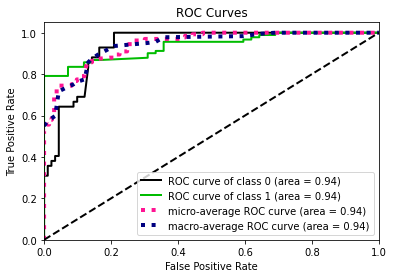

0.9358974358974359


In [68]:
plot_roc(Y_test, svm_model.predict_proba(X_test_vec))
plt.show()
print(roc_auc_score(Y_test, y_test_pred_proba[:,1], average="macro"))

In [27]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [28]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear', 'poly'],
              'class_weight':['balanced', None],
}

In [29]:
grid = GridSearchCV(SVC(), param_grid, refit = True, scoring = "accuracy", cv=kfold, verbose=3)
grid.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.710 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.758 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.768 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.707 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.788 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.770 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.838 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.828 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.768 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=lin

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy', verbose=3)

In [30]:
print(grid.best_params_)

{'C': 1, 'class_weight': None, 'gamma': 1, 'kernel': 'rbf'}


In [31]:
grid_predictions = grid.predict(X_test_vec)
print(classification_report(Y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81        42
           1       0.94      0.87      0.90        91

    accuracy                           0.87       133
   macro avg       0.85      0.87      0.86       133
weighted avg       0.88      0.87      0.87       133

